# Coursera Capstone Project

## The Battle of Neighbourhoods - Final Report (Week 1 and 2)

## 1. Introduction and Business Problem

### Project Background

London is an ever-growing city, the most populated in the United Kingdom. It has a wide diversity being made up of many groups of different cultures; as well as being the financial capital of the UK. It is a global hub of business and commerce. The city is a major center for banking and finance, retailing, world trade, transportation, tourism, real estate, new media, traditional media, advertising, legal services, accountancy, insurance, theater, fashion, and the arts in the UK.


### Project Description

This project aims to find a suitable hotel based on location, price and venues. In order to make a comparison and evaluation of the hotel options in London, I have set a basis, therefore the apartment in London must meet the following requirements:

The hotel will have 2 beds in 1 room for 2 adults and 1 child. The price of rent not exceed £1,000 during the stay. It must be desirable to have venues such as cafés/coffeeshops, a restaurant, and a theatre.

### Target Audience
The target audience for this will be aimed at those (either internal or external migrants) visiting London briefly, wanting to stay close to its many types of venues. In this particular project it focuses on a family of three.

## 2.  Data Section

### Description of the data and its sources that will be used to solve the problem.

How the data will be used to solve the problem:

Data will be extracted from Wikipedia's table using the beautiful soup library: https://en.wikipedia.org/wiki/London_boroughs

London has several boroughs and neighbourhoods. To segment and the explore the neighbourhoods, a dataset will be created that has each borough.

Geocoder will be used to obtain a list of latitudes and longitudes for each borough. As well as a list of hotels in London area with their addresses and price acquired from https://www.expedia.ie/Hotel-Search?GOTO=HOTSEARCH&SearchArea=City&SearchType=Place&adults=2&children=1_13&destination=London%20%28and%20vicinity%29%2C%20England%2C%20United%20Kingdom&endDate=2021-08-13&lang=2057&latLong=&needUTF8Decode=true&regionId=178279&rfrr=hotel.search&selected=&semdtl=&sort=RECOMMENDED&startDate=2021-08-10&theme=&useRewards=false&userIntent= .

Then after modifications, information gathered will be input through FourSquare API and geopy data to retrive information on London's most common venues of selected boroughs. As well as map the location of hotels, in some form, linked to the cluster of venues. Addresses from hotel locations will be converted to geodata(lat, long) using Geopy-distance and Nominatim.

## 3.  Methodology

### Upload the necessary libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner
import time
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

!pip install lxml

!pip install bs4
from bs4 import BeautifulSoup

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from folium import plugins

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans


print('Libraries imported.')

     |████████████████████████████████| 122kB 975kB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.52         |     pyhd8ed1ab_0          35 KB  conda-forge
    geopy-2.2.0                |     pyhd8ed1ab_0          67 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         102 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.52-pyhd8ed1ab_0
  geopy              conda-forge/noarch::geopy-2.2.0-pyhd8ed1ab_0



geographiclib-1.52   | 35 K

### Scrape Neighbourhood Data

In [2]:
# Get the neighborhood data using beautiful soup 
url='https://en.wikipedia.org/wiki/List_of_London_boroughs'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

# read the data into a Pandas Dataframe
soup = BeautifulSoup(str(data_html))

In [3]:
BoroughName = []
Coordinates = []

for row in soup.find('table').find_all('tr'):
    cells = row.find_all('td')
    if len(cells) > 0:
        BoroughName.append(cells[0].text.rstrip('\n'))
        Coordinates.append(cells[8].text.rstrip('\n'))

In [4]:
# Form a dataframe
dict = {'BoroughName' : BoroughName,
       'Coordinates': Coordinates}
info = pd.DataFrame.from_dict(dict)
info.head()

,BoroughName,Coordinates
0,Barking and Dagenham[note 1],51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...


In [5]:
# Strip unwanted texts
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip(']'))
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip('1234567890.'))
info['BoroughName'] = info['BoroughName'].str.replace('note','')
info['BoroughName'] = info['BoroughName'].map(lambda x: x.rstrip(' ['))
info.head()

,BoroughName,Coordinates
0,Barking and Dagenham,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...


In [6]:
# Clean coordinates
info[['Coordinates1','Coordinates2','Coordinates3']] = info['Coordinates'].str.split('/',expand=True)
info.head()

,BoroughName,Coordinates,Coordinates1,Coordinates2,Coordinates3
0,Barking and Dagenham,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E﻿ /...,51°33′39″N 0°09′21″E﻿,﻿51.5607°N 0.1557°E﻿,51.5607; 0.1557﻿ (Barking and Dagenham)
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W﻿ /...,51°37′31″N 0°09′06″W﻿,﻿51.6252°N 0.1517°W﻿,51.6252; -0.1517﻿ (Barnet)
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E﻿ /...,51°27′18″N 0°09′02″E﻿,﻿51.4549°N 0.1505°E﻿,51.4549; 0.1505﻿ (Bexley)
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W﻿ /...,51°33′32″N 0°16′54″W﻿,﻿51.5588°N 0.2817°W﻿,51.5588; -0.2817﻿ (Brent)
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E﻿ /...,51°24′14″N 0°01′11″E﻿,﻿51.4039°N 0.0198°E﻿,51.4039; 0.0198﻿ (Bromley)


In [7]:
info.drop(labels=['Coordinates','Coordinates1','Coordinates2'], axis=1,inplace = True)
info[['Latitude','Longitude']] = info['Coordinates3'].str.split(';',expand=True)
info.head()

,BoroughName,Coordinates3,Latitude,Longitude
0,Barking and Dagenham,51.5607; 0.1557﻿ (Barking and Dagenham),51.5607,0.1557﻿ (Barking and Dagenham)
1,Barnet,51.6252; -0.1517﻿ (Barnet),51.6252,-0.1517﻿ (Barnet)
2,Bexley,51.4549; 0.1505﻿ (Bexley),51.4549,0.1505﻿ (Bexley)
3,Brent,51.5588; -0.2817﻿ (Brent),51.5588,-0.2817﻿ (Brent)
4,Bromley,51.4039; 0.0198﻿ (Bromley),51.4039,0.0198﻿ (Bromley)


In [8]:
info.drop(labels=['Coordinates3'], axis=1,inplace = True)
info['Latitude'] = info['Latitude'].map(lambda x: x.rstrip(u'\ufeff'))
info['Latitude'] = info['Latitude'].map(lambda x: x.lstrip())
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(')'))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(' ('))
info['Longitude'] = info['Longitude'].map(lambda x: x.rstrip(u'\ufeff'))
info['Longitude'] = info['Longitude'].map(lambda x: x.lstrip())
info.head()

,BoroughName,Latitude,Longitude
0,Barking and Dagenham,51.5607,0.1557
1,Barnet,51.6252,-0.1517
2,Bexley,51.4549,0.1505
3,Brent,51.5588,-0.2817
4,Bromley,51.4039,0.0198


In [9]:
info['BoroughName'].unique()

array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich', 'Hackney',
       'Hammersmith and Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington and Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster'],
      dtype=object)

###  Foursquare API

List of top 50 popular places in the borough

source: Foursquare    

url: https://api.foursquare.com

In [58]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 
CLIENT_SECRET:


In [11]:
#Create a function to explore all borough
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['BoroughName', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [12]:
#Get top 50 venues in 500m radius of the center of each Borough
LIMIT = 50
venues = getNearbyVenues(names=info['BoroughName'],
                                   latitudes=info['Latitude'],
                                   longitudes=info['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [13]:
print(venues.shape)
venues.head()

(1132, 7)


,BoroughName,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Central Park,51.559560,0.161981,Park
1,Barking and Dagenham,51.5607,0.1557,Morrisons,51.559774,0.148752,Supermarket
2,Barking and Dagenham,51.5607,0.1557,Crowlands Heath Golf Course,51.562457,0.155818,Golf Course
3,Barking and Dagenham,51.5607,0.1557,Robert Clack Leisure Centre,51.560808,0.152704,Martial Arts School
4,Barking and Dagenham,51.5607,0.1557,Beacontree Heath Leisure Centre,51.560997,0.148932,Gym / Fitness Center


### Let's check how many venues were returned for each borough

In [14]:
venues.groupby('BoroughName').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
BoroughName,,,,,,
Barking and Dagenham,7,7,7,7,7,7
Barnet,4,4,4,4,4,4
Bexley,26,26,26,26,26,26
Brent,50,50,50,50,50,50
Bromley,38,38,38,38,38,38
Camden,50,50,50,50,50,50
Croydon,37,37,37,37,37,37
Ealing,50,50,50,50,50,50
Enfield,50,50,50,50,50,50


### Let's find out how many unique categories can be curated from all the returned venues

In [15]:
print('There are {} uniques categories.'.format(len(venues['Venue Category'].unique())))

There are 187 uniques categories.


### Analyze Each Borough

In [16]:
# one hot encoding
london_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['BoroughName'] = venues['BoroughName'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,BoroughName,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Casino,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food Court,French Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Historic Site,History Museum,Hobby Shop,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lighting Store,Liquor Store,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsagent,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Mall,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Shoe Store,Shopping Mall,Social Club,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### And let's examine the new dataframe size.

In [17]:
london_onehot.shape

(1132, 188)

#### Next, let's group rows by borough and by taking the mean of the frequency of occurrence of each category

In [18]:
london_grouped = london_onehot.groupby('BoroughName').mean().reset_index()
london_grouped

,BoroughName,African Restaurant,Airport Lounge,Airport Service,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bakery,Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bistro,Boarding House,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Casino,Chaat Place,Champagne Bar,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Currency Exchange,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Discount Store,Donut Shop,Dumpling Restaurant,Electronics Store,English Restaurant,Escape Room,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food Court,French Restaurant,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gelato Shop,German Restaurant,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Historic Site,History Museum,Hobby Shop,Home Service,Hotel,Hotel Bar,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Latin American Restaurant,Light Rail Station,Lighting Store,Liquor Store,Malay Restaurant,Market,Martial Arts School,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Modern European Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsagent,Nightclub,Noodle House,Okonomiyaki Restaurant,Optical Shop,Organic Grocery,Outdoor Sculpture,Outlet Mall,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pharmacy,Pizza Place,Platform,Playground,Plaza,Polish Restaurant,Pool,Portuguese Restaurant,Pub,Public Art,Rafting,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Roof Deck,Salad Place,Sandwich Place,Scenic Lookout,Shoe Store,Shopping Mall,Social Club,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Street Art,Street Food Gathering,Supermarket,Sushi Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Tiki Bar,Toy / Game Store,Train Station,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Yoga Studio
0,Barking and Dagenham,0.00000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.142857,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00,0.000000,0.142857,0.000000,0.000000,0.000000,0.142857,0.00,0.00000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.142857,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.00000,0.00,0.00,0.142857,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.142857,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.00,0.00000,0.000000,0.00,0.00,0.142857,0.000000,0.00,0.000000,0.00,0.00

### Let's print each borough along with the top 5 most common venues

In [19]:
num_top_venues = 5

for hood in london_grouped['BoroughName']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['BoroughName'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
                  venue  freq
0  Gym / Fitness Center  0.14
1                  Pool  0.14
2           Supermarket  0.14
3           Golf Course  0.14
4                  Park  0.14


----Barnet----
                 venue  freq
0                 Café  0.50
1     Business Service  0.25
2  Rental Car Location  0.25
3   African Restaurant  0.00
4                 Park  0.00


----Bexley----
                  venue  freq
0                   Pub  0.12
1        Clothing Store  0.12
2           Coffee Shop  0.12
3           Supermarket  0.08
4  Fast Food Restaurant  0.08


----Brent----
                 venue  freq
0                Hotel  0.10
1          Coffee Shop  0.10
2       Clothing Store  0.06
3        Grocery Store  0.06
4  Sporting Goods Shop  0.06


----Bromley----
            venue  freq
0  Clothing Store  0.16
1     Coffee Shop  0.13
2             Bar  0.05
3     Pizza Place  0.05
4    Burger Joint  0.05


----Camden----
            venue  freq
0         

In [14]:
# function that extracts the category of the venue - MERGE THESE TWO WITH ABOVE???????
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

### Let's put that into a pandas dataframe

#### First, let's write a function to sort the venues in descending order.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's create the new dataframe and display the top 10 venues for each borough.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['BoroughName']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['BoroughName'] = london_grouped['BoroughName']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pool,Golf Course,Bus Station,Supermarket,Park,Gym / Fitness Center,Martial Arts School,Fish Market,Fish & Chips Shop,Fast Food Restaurant
1,Barnet,Café,Business Service,Rental Car Location,Yoga Studio,Escape Room,Food Court,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
2,Bexley,Coffee Shop,Pub,Clothing Store,Fast Food Restaurant,Pharmacy,Supermarket,Bakery,Italian Restaurant,Furniture / Home Store,Department Store
3,Brent,Hotel,Coffee Shop,Sporting Goods Shop,Clothing Store,Grocery Store,American Restaurant,Sandwich Place,Bar,Outdoor Sculpture,Plaza
4,Bromley,Clothing Store,Coffee Shop,Bar,Pizza Place,Burger Joint,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Noodle House,Donut Shop


In [24]:
kclusters = 5
london_cluster = london_grouped.drop('BoroughName', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_cluster)

kmeans.labels_[0:10]

array([4, 2, 3, 0, 3, 0, 0, 0, 3, 3], dtype=int32)

In [26]:
# add clustering labels


neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto coords to add latitude/longitude for each neighborhood
london_merged = info
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('BoroughName'), on='BoroughName')

london_merged.head()

,BoroughName,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,51.5607,0.1557,4,Pool,Golf Course,Bus Station,Supermarket,Park,Gym / Fitness Center,Martial Arts School,Fish Market,Fish & Chips Shop,Fast Food Restaurant
1,Barnet,51.6252,-0.1517,2,Café,Business Service,Rental Car Location,Yoga Studio,Escape Room,Food Court,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant
2,Bexley,51.4549,0.1505,3,Coffee Shop,Pub,Clothing Store,Fast Food Restaurant,Pharmacy,Supermarket,Bakery,Italian Restaurant,Furniture / Home Store,Department Store
3,Brent,51.5588,-0.2817,0,Hotel,Coffee Shop,Sporting Goods Shop,Clothing Store,Grocery Store,American Restaurant,Sandwich Place,Bar,Outdoor Sculpture,Plaza
4,Bromley,51.4039,0.0198,3,Clothing Store,Coffee Shop,Bar,Pizza Place,Burger Joint,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Noodle House,Donut Shop


In [27]:
address = 'London, UK'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

51.5073219 -0.1276474


### Let's convert string to numeric

In [28]:
london_merged[['Latitude', 'Longitude']] = london_merged[['Latitude', 'Longitude']].apply(pd.to_numeric)

### Create a map of the various clusters

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['BoroughName'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

In [35]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Brent,Hotel,Coffee Shop,Sporting Goods Shop,Clothing Store,Grocery Store,American Restaurant,Sandwich Place,Bar,Outdoor Sculpture,Plaza
5,Camden,Hotel,Café,Coffee Shop,Breakfast Spot,Pizza Place,Bakery,Train Station,Pub,Market,Burger Joint
6,Croydon,Pub,Coffee Shop,Korean Restaurant,Portuguese Restaurant,Asian Restaurant,Spanish Restaurant,Bus Stop,Malay Restaurant,Gaming Cafe,Burger Joint
7,Ealing,Coffee Shop,Park,Italian Restaurant,Pub,Pizza Place,Clothing Store,Burger Joint,Hotel,Vietnamese Restaurant,Organic Grocery
10,Hackney,Pub,Coffee Shop,Cocktail Bar,Brewery,Bakery,Grocery Store,Modern European Restaurant,Organic Grocery,Café,Vegetarian / Vegan Restaurant
11,Hammersmith and Fulham,Pub,Indian Restaurant,Italian Restaurant,Gastropub,Café,Vietnamese Restaurant,Japanese Restaurant,Garden Center,Furniture / Home Store,French Restaurant
12,Haringey,Turkish Restaurant,Pub,Convenience Store,Supermarket,Indian Restaurant,Italian Restaurant,Gym / Fitness Center,Grocery Store,Light Rail Station,Gaming Cafe
17,Islington,Pub,Bakery,Theater,Ice Cream Shop,Burger Joint,Café,Boutique,Cocktail Bar,Music Venue,Record Shop
18,Kensington and Chelsea,Café,Juice Bar,Clothing Store,Restaurant,Bakery,French Restaurant,Gym / Fitness Center,Burger Joint,Modern European Restaurant,Mediterranean Restaurant
19,Kingston upon Thames,Coffee Shop,Department Store,Burger Joint,Pub,Café,Sushi Restaurant,Thai Restaurant,Cajun / Creole Restaurant,Latin American Restaurant,Market


In [36]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Hounslow,Bed & Breakfast,Pizza Place,Café,Park,Yoga Studio,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant,Farmers Market


In [37]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Barnet,Café,Business Service,Rental Car Location,Yoga Studio,Escape Room,Food Court,Flea Market,Fish Market,Fish & Chips Shop,Fast Food Restaurant


In [39]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Bexley,Coffee Shop,Pub,Clothing Store,Fast Food Restaurant,Pharmacy,Supermarket,Bakery,Italian Restaurant,Furniture / Home Store,Department Store
4,Bromley,Clothing Store,Coffee Shop,Bar,Pizza Place,Burger Joint,Furniture / Home Store,Fast Food Restaurant,Electronics Store,Noodle House,Donut Shop
8,Enfield,Clothing Store,Coffee Shop,Optical Shop,Supermarket,Pub,Newsagent,Department Store,Pharmacy,Café,Video Game Store
9,Greenwich,Pub,Clothing Store,Fast Food Restaurant,Coffee Shop,Supermarket,Hotel,Grocery Store,Pharmacy,Asian Restaurant,Platform
13,Harrow,Indian Restaurant,Grocery Store,Coffee Shop,Fast Food Restaurant,Supermarket,Thai Restaurant,Platform,Indie Movie Theater,Hobby Shop,Dumpling Restaurant
14,Havering,Coffee Shop,Clothing Store,Shopping Mall,Hotel,Fast Food Restaurant,Café,Pub,Bakery,Chinese Restaurant,Supermarket
15,Hillingdon,Coffee Shop,Clothing Store,Fast Food Restaurant,Pharmacy,Pub,Toy / Game Store,Italian Restaurant,Burger Joint,Electronics Store,Music Store
21,Lewisham,Supermarket,Coffee Shop,Grocery Store,Platform,Pub,Italian Restaurant,Bus Stop,Train Station,Bakery,Fast Food Restaurant
22,Merton,Supermarket,Café,Irish Pub,Italian Restaurant,Grocery Store,Garden Center,Fast Food Restaurant,Park,Pizza Place,Coffee Shop
24,Redbridge,Fast Food Restaurant,Supermarket,Grocery Store,Clothing Store,Coffee Shop,Sandwich Place,Pub,Bakery,Sports Bar,Buffet


In [40]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,BoroughName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Pool,Golf Course,Bus Station,Supermarket,Park,Gym / Fitness Center,Martial Arts School,Fish Market,Fish & Chips Shop,Fast Food Restaurant


### A large cluster of venues we are looking for are found in the inner-city. Let's create a map to show this

In [43]:

map_clusters = folium.Map(location=[51.5073219, -0.1276474], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['BoroughName'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
                                 
                                            

# Map of Manhattan places for rent

## Now that we have an idea of venues, let's find suitable hotels in the area.

### Upload the csv of hotel data 

In [44]:
ldnhotel_data = pd.read_csv('2021LondonHotels.csv')
ldnhotel_data.head()

,ID,Name,Address,Borough,Postcode,Reviews,Price for 3 Nights (£),Lat,Long
0,0,DoubleTree by Hilton London Angel Kings Cross,60 Pentonville Road,Islington,N1 9LA,4.2,217,NaN,NaN
1,1,Ibis Budget London Hounslow,20-28 Staines Road,Hounslow,TW3 3JS,3.5,104,NaN,NaN
2,2,Bankside Hotel,"2 Blackfriars Road, Upper Ground",Southwark,SE1 9JU,4.8,717,NaN,NaN
3,3,The Resident Soho,10 Carlisle Street,Westminster,W1D 3BR,4.5,478,NaN,NaN
4,4,Apex Temple Court Hotel,"1-2 Serjeants Inn, Fleet Street",City of London,EC4Y 1AG,4.7,3177,NaN,NaN


In [45]:
ldnhotel_data.tail()

,ID,Name,Address,Borough,Postcode,Reviews,Price for 3 Nights (£),Lat,Long
9,9,Park Plaza County Hall London,1 Addington Street,Lambeth,SE1 7RY,4.4,478,NaN,NaN
10,10,Staybridge Suites London,100 Vauxhall Walk,Lambeth,SE11 5EL,4.7,560,NaN,NaN
11,11,SACO Fitzrovia,21 Tottenham Street,Camden,W1T 2AW,4.5,517,NaN,NaN
12,12,The Piccadilly London West End,"65-73 Shaftesbury Avenue, Piccadilly",Westminster,W1D 6EX,4.1,901,NaN,NaN
13,13,Hampton by Hilton London Waterloo,"157 Waterloo Road, Waterloo",Lambeth,SE1 8XA,4.4,346,NaN,NaN


## The initial data for 14 hotels did not have the latitude and longitude data (NaN) but the information was established in the following cell using an algorythm and Nominatim

## Obtain geodata ( lat,long) for each rental place in Manhattan with Nominatim

In [46]:
ldnhotel_data.drop(labels=['ID'], axis=1,inplace = True)

In [47]:
for n in range(len(ldnhotel_data)):   
    address= ldnhotel_data['Postcode'][n]
    address=(ldnhotel_data['Postcode'][n]+ '  , '+' London UK ')
    geolocator = Nominatim(user_agent="Dáibhéid")
    location = geolocator.geocode(address)
    print(location)
    if(location):
        latitude = location.latitude
    
        longitude = location.longitude
        ldnhotel_data['Lat'][n]=latitude
        ldnhotel_data['Long'][n]=longitude
    #print(n,latitude,longitude)
        time.sleep(2)

print('Geodata completed')
# save dataframe to csv file
ldnhotel_data.to_csv('ldnhotel_latlong.csv',index=False)
ldnhotel_data.shape

London Borough of Islington, England, N1 9LA, United Kingdom


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


London Borough of Hounslow, England, TW3 3JS, United Kingdom
London Borough of Southwark, England, SE1 9JU, United Kingdom
Soho, London, City of Westminster, England, W1D 3BR, United Kingdom
City of London, England, EC4Y 1AG, United Kingdom
London Borough of Lambeth, England, SE1 7PB, United Kingdom
London Borough of Southwark, England, SE1 0UG, United Kingdom
Chinatown, London, City of Westminster, England, W1D 6QF, United Kingdom
London Borough of Southwark, England, SE1 8NY, United Kingdom
London Borough of Lambeth, England, SE1 7RY, United Kingdom
London Borough of Lambeth, England, SE11 5EL, United Kingdom
Estée Lauder Companies UK & Ireland, 1, Fitzroy Place, Fitzrovia, London, City of Westminster, England, W1W 7EY, United Kingdom
Soho, London, City of Westminster, England, W1D 6EX, United Kingdom
London Borough of Lambeth, England, SE1 8XA, United Kingdom
Geodata completed


(14, 8)

In [48]:
ldnhotel_data=pd.read_csv('ldnhotel_latlong.csv')
ldnhotel_data.head(14)

,Name,Address,Borough,Postcode,Reviews,Price for 3 Nights (£),Lat,Long
0,DoubleTree by Hilton London Angel Kings Cross,60 Pentonville Road,Islington,N1 9LA,4.2,217,51.532111,-0.109466
1,Ibis Budget London Hounslow,20-28 Staines Road,Hounslow,TW3 3JS,3.5,104,51.467295,-0.366824
2,Bankside Hotel,"2 Blackfriars Road, Upper Ground",Southwark,SE1 9JU,4.8,717,51.507693,-0.105322
3,The Resident Soho,10 Carlisle Street,Westminster,W1D 3BR,4.5,478,51.514739,-0.134111
4,Apex Temple Court Hotel,"1-2 Serjeants Inn, Fleet Street",City of London,EC4Y 1AG,4.7,3177,51.513816,-0.108900
5,London Marriott Hotel County Hall,"London County Hall, Westminster Bridge Road",Southwark,SE1 7PB,4.4,912,51.501905,-0.119047
6,Hilton London Bankside,2-8 Great Suffolk Street,Southwark,SE1 0UG,4.7,745,51.505319,-0.101517
7,W London,"10 Wardour Street, Soho",Westminster,W1D 6QF,4.2,984,51.511032,-0.131562
8,The Hoxton Southwark,Blackfriars Road 32- 40,Southwark,SE1 8NY,4.6,564,51.506230,-0.105186
9,Park Plaza County Hall London,1 Addington Street,Lambeth,SE1 7RY,4.4,478,51.501195,-0.115712


## London hotel price statistics

<AxesSubplot:xlabel='Price for 3 Nights (£)'>

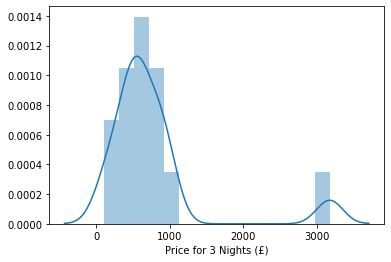

In [31]:
import seaborn as sns
sns.distplot(ldnhotel_data['Price for 3 Nights (£)'],bins=15)

<AxesSubplot:xlabel='Reviews'>

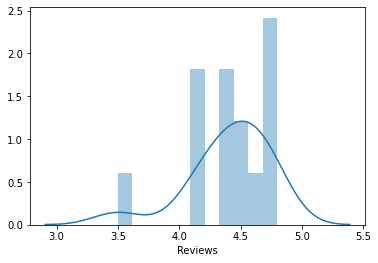

In [32]:
sns.distplot(ldnhotel_data['Reviews'],bins=11)

<AxesSubplot:xlabel='Reviews', ylabel='Price for 3 Nights (£)'>

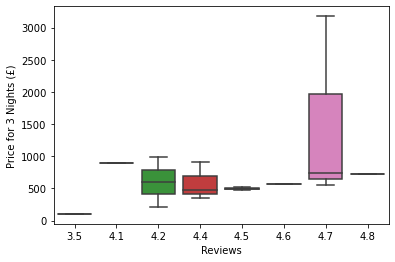

In [33]:
sns.boxplot(x='Reviews', y= 'Price for 3 Nights (£)', data=ldnhotel_data)

## Map of London hotels

In [52]:
# create map of London using latitude and longitude values from Nominatim
latitude= 51.5073219
longitude= -0.1276474

map_london_hotel = folium.Map(location=[latitude, longitude], zoom_start=13.5)

# add markers to map
for lat, lng, label in zip(ldnhotel_data['Lat'], ldnhotel_data['Long'],'$ ' + ldnhotel_data['Price for 3 Nights (£)'].astype(str)+ ',  '+ ldnhotel_data['Address']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_hotel) 
    

map_london_hotel

# 4. Results & Recommendation

## Now we will review all the analysis made in this project before we make a conclusion on which area to stay as a traveller.
## Like mentioned in the beginning, our key criteria of location decision will be based on venues and price of hotels.

## Map of London showing the places to stay and the cluster of venues

### Now, one can point to a rental place for price and address location information while knowing the cluster venues around it.
### This is an insightful way to explore hotel possibilites

In [57]:
# create map of London using latitude and longitude values from Nominatim
latitude= 51.5073219
longitude= -0.1276474

# create map with clusters
kclusters=5
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['BoroughName'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)

# add markers to map for hotel places
for lat, lng, label in zip(ldnhotel_data['Lat'], ldnhotel_data['Long'],'$ ' + ldnhotel_data['Price for 3 Nights (£)'].astype(str)+ ldnhotel_data['Name']):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
    
    # Adds tool to the top right
from folium.plugins import MeasureControl
map_london_hotel.add_child(MeasureControl())

# FMeasurement ruler icon to establish distnces on map
from folium.plugins import FloatImage
url = ('https://media.licdn.com/mpr/mpr/shrinknp_100_100/AAEAAQAAAAAAAAlgAAAAJGE3OTA4YTdlLTkzZjUtNDFjYy1iZThlLWQ5OTNkYzlhNzM4OQ.jpg')
FloatImage(url, bottom=5, left=85).add_to(map_london_hotel)

map_clusters2

# 5. Conclusion
## From our analysis, we have found that boroughs from Cluster 0 such as Westminster, Camden, and Southwark are the best places to visit for theatre, restaurants, and coffeeshops. A predominant amount of hotels lie within this boroughs are under £1,000.